## Three data-driven tips on starting a profitable Airbnb business in NYC

It can be both exciting and nerve-racking to start an Airbnb business in New York City, the No. 1 touriest destination in the US. On one hand, you have heard of numerous successful stories and are eager to make your own luck. On the other hand, you may be bothered by fundamental questions, such as which property to invest in and what is a fair price for your lisitng. 

This notebook uses a data-driven approach to help new hosts get started. It looked into a [Kaggle dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) that contained NYC Airbnb listings in the year of 2019, analyzed details of each listing such as the price and location, and finally provided **three tips to potential hosts on starting a profitable Airbnb business:**
    
1. [<span style="color:#1dacd6">What type of property to invest in</span>](#first-bullet)
2. [<span style="color:#1dacd6">How to price your lisitng</span>](#second-bullet)
3. [<span style="color:#1dacd6">How to name/describe your listing</span>](#third-bullet)


## 0. Data Cleaning and Inspection

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import multidict as multidict
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from PIL import Image
from io import BytesIO

In [176]:
# load raw data
df = pd.read_csv('./AB_NYC_2019.csv')

# focus on reasonable listings only 
# reasonable listings = price between (0,600], availability >= 1 day, minimum nights per stay < 60
listings = df[(df.price > 0) & (df.price <= 600) & (df.availability_365>0) & (df.minimum_nights<60)]
   
# drop personal information
listings = listings.drop('host_name', axis=1)

# fill nan
listings['reviews_per_month'].fillna(0, inplace=True)

listings.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


## 1. What type of property to invest in<a class="anchor" id="first-bullet"></a>
If you do not own a property yet, you probably need to find a property worth investing in first. Which neighbourhood was most popular? Which neighbourhood had the highest average listing price? Did people offer an entire apartment or a private bedroom? Let's find out.

### 1.1 Which neighbourhood was most popular?

Manhattan        12901
Brooklyn         12023
Queens            4264
Bronx              897
Staten Island      325
Name: neighbourhood_group, dtype: int64


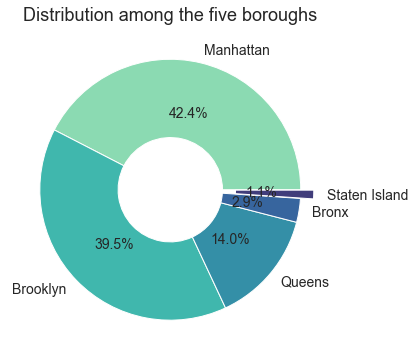

In [227]:
# borough-wise distribution
borough_distribution = listings.neighbourhood_group.value_counts()
print(borough_distribution)

plt.figure(figsize = (8,6))
plt.pie(borough_distribution, autopct="%.1f%%", labels = borough_counts.index, \
        colors = sns.color_palette('mako_r'), explode = [0,0,0,0,0.1], \
        textprops={'fontsize': 14}, wedgeprops=dict(width=0.6))
plt.title('Distribution among the five boroughs');

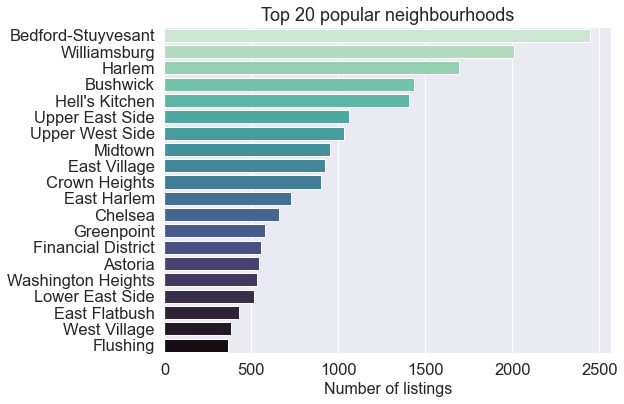

In [226]:
# top 20 popular neighbourhoods
popular_neighbourhoods = listings.neighbourhood.value_counts()[:20]

plt.figure(figsize = (8,6))
sns.barplot(y = popular_neighbourhoods.index, x = popular_neighbourhoods.values, palette='mako_r')
plt.xlabel("Number of listings", fontsize = 16)
plt.title('Top 20 popular neighbourhoods');

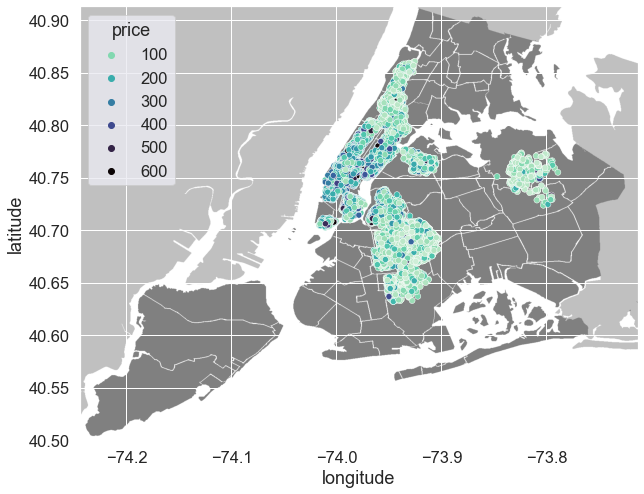

In [290]:
# might be fun to also visualize those popular neighbourhood on the map
sub = listings[listings['neighbourhood'].isin(popular_neighbourhoods.index)]

# show NYC map
url = 'https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG'
response = requests.get(url)
nyc_img = Image.open(BytesIO(response.content))
plt.figure(figsize=(10,12))
plt.imshow(nyc_img,zorder=0,extent=[listings.longitude.min(), listings.longitude.max(), \
                                    listings.latitude.min(),listings.latitude.max()])

# overlay scatter plot
sns.scatterplot(data = sub, x = 'longitude', y = 'latitude', hue = 'price', palette='mako_r');
plt.title('Top 20 popular neighbourhoods')


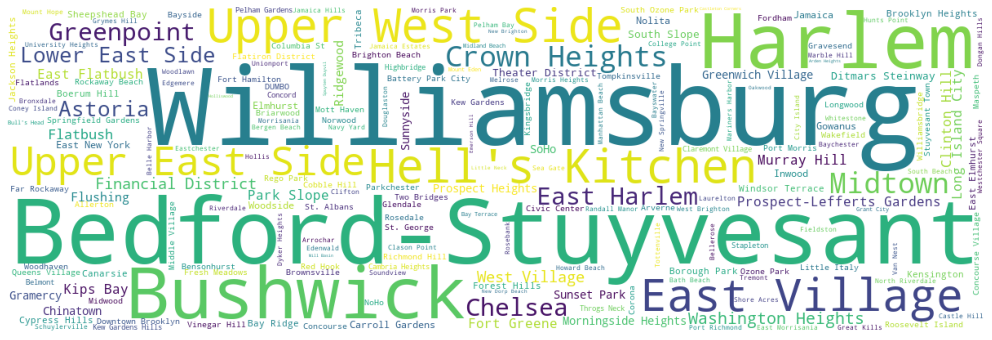

In [250]:
# a frequency-based word cloud of neighbourhoods, just for fun
neighbourhood_dict = dict(df['neighbourhood'].value_counts().apply(lambda x:int(x)))
fullTermsDict = multidict.MultiDict()
for key in neighbourhood_dict:
    fullTermsDict.add(key, neighbourhood_dict[key])

plt.figure(figsize = (18,6))
neighbourhood_dict = df['neighbourhood'].value_counts
wordcloud = WordCloud(
                          background_color='white',
                          width=1200,
                          height=400
                         ).generate_from_frequencies(fullTermsDict)
plt.imshow(wordcloud)
plt.axis('off');
# plt.savefig('WordCloud.png');

### 1.2 Which neighbourhood had the highest average listing price?

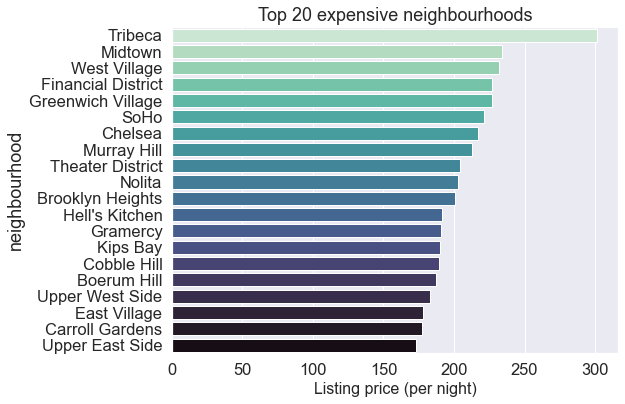

In [268]:
# top 20 expensive neighbourhoods with more than 50 listings
mask = listings.groupby('neighbourhood')['neighbourhood'].transform('count')>50
expensive_neighbourhoods = listings[mask].groupby('neighbourhood')['price'].mean().sort_values(ascending=False)[:20]

plt.figure(figsize = (8,6))
sns.barplot(y = expensive_neighbourhoods.index, x = expensive_neighbourhoods.values, palette='mako_r')
plt.xlabel("Listing price (per night)", fontsize = 16)
plt.title('Top 20 expensive neighbourhoods');

Text(0.5, 1.0, 'Top 20 expensive neighbourhoods')

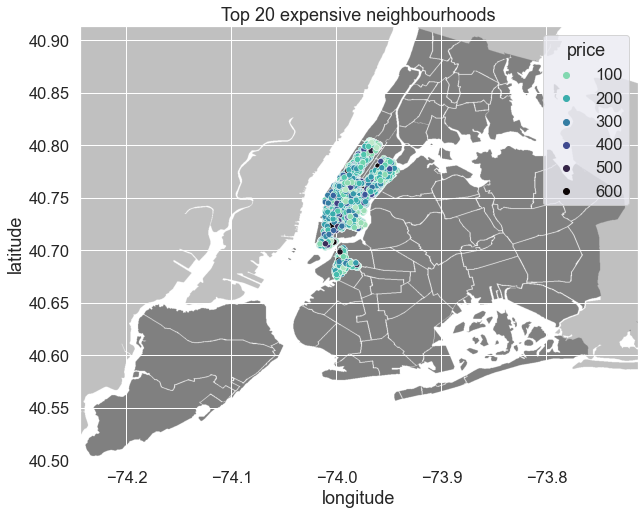

In [291]:
# let's also visualize those pricey neighbourhood on the map
sub = listings[listings['neighbourhood'].isin(expensive_neighbourhoods.index)]

# show NYC map
url = 'https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG'
response = requests.get(url)
nyc_img = Image.open(BytesIO(response.content))
plt.figure(figsize=(10,12))
plt.imshow(nyc_img,zorder=0,extent=[listings.longitude.min(), listings.longitude.max(), \
                                    listings.latitude.min(),listings.latitude.max()])

# overlay scatter plot
sns.scatterplot(data = sub, x = 'longitude', y = 'latitude', hue = 'price', palette='mako_r');
plt.title('Top 20 expensive neighbourhoods')

In [270]:
# neighbourhoods that are both popular and pricey
print("Both popular and pricey:")
for neighbourhood in np.intersect1d(popular_neighbourhoods.index, expensive_neighbourhoods.index):
    print('-',neighbourhood)

Both popular and pricey:
- Chelsea
- East Village
- Financial District
- Hell's Kitchen
- Midtown
- Upper East Side
- Upper West Side
- West Village


### 1.3 Did people offer an entire apartment or a private bedroom?

Entire home/apt    15788
Private room       13771
Shared room          851
Name: room_type, dtype: int64


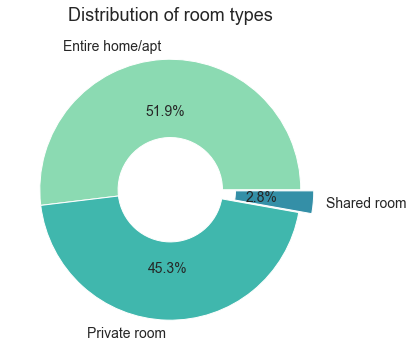

In [251]:
# room_type distribution
roomtype_distribution = listings.room_type.value_counts()
print(roomtype_distribution)

plt.figure(figsize = (8,6))
plt.pie(roomtype_distribution, autopct="%.1f%%", labels = roomtype_distribution.index, \
        colors = sns.color_palette('mako_r'), explode = [0,0,0.1], \
        textprops={'fontsize': 14}, wedgeprops=dict(width=0.6));
plt.title('Distribution of room types');

To follow the trend or to fill the niche? That's your own decision. 
Would be a more powerful decision if we could also consider the cost, but not included in this dataset.

## 2. How to price your listing<a class="anchor" id="second-bullet"></a>

In [125]:
# only use popular listings (with resonable amount of reviews) for regression model
listings_popular = listings[listings['reviews_per_month']>=1]

In [142]:
X = listings_popular[['neighbourhood_group', 'neighbourhood', 'room_type', 'minimum_nights',\
                      'number_of_reviews', 'reviews_per_month', 'availability_365']]
X_enc = pd.get_dummies(data = X, columns = ['neighbourhood_group','neighbourhood','room_type'], \
                             prefix = ['nbg','nb','rt'])
y = listings_popular['price']

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(12000, 220) (12000,) (3000, 220) (3000,)


In [144]:
# Initiate classifier to use
# model = lgb.LGBMRegressor() # 4039
# model = xgb.XGBRegressor()
model = RandomForestRegressor() # 2318 3820

# lgb params
gridParams = {
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200],
    'num_leaves': [31, 62], # large num_leaves helps improve accuracy but might lead to over-fitting
    'max_depth': [-1,5,8], # <0 means no limit
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'random_state' : [42],
    'reg_alpha' : [0, 0.2],
    'reg_lambda' : [0, 0.2],
    }

# rf params
gridParams = {
    'n_estimators': [200, 250],
    'max_features': [35,50,65],
    'min_samples_leaf': [1, 2, 3], 
    'max_depth': [None,16,32,48], # <0 means no limit
    'random_state' : [42],
    }

grid = GridSearchCV(model, gridParams, scoring = 'neg_mean_squared_error', verbose=3, cv=2, n_jobs=1)
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

y_pred_train = grid.predict(X_train)
mse_train = mean_squared_error(y_pred_train, y_train)
y_pred = grid.predict(X_test)
mse_test = mean_squared_error(y_pred, y_test)
print(mse_train, mse_test)

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV 1/2] END max_depth=None, max_features=35, min_samples_leaf=1, n_estimators=200, random_state=42;, score=-3870.165 total time=   4.4s
[CV 2/2] END max_depth=None, max_features=35, min_samples_leaf=1, n_estimators=200, random_state=42;, score=-4213.862 total time=   4.7s
[CV 1/2] END max_depth=None, max_features=35, min_samples_leaf=1, n_estimators=250, random_state=42;, score=-3861.086 total time=   5.2s
[CV 2/2] END max_depth=None, max_features=35, min_samples_leaf=1, n_estimators=250, random_state=42;, score=-4215.835 total time=   5.1s
[CV 1/2] END max_depth=None, max_features=35, min_samples_leaf=2, n_estimators=200, random_state=42;, score=-3801.283 total time=   3.3s
[CV 2/2] END max_depth=None, max_features=35, min_samples_leaf=2, n_estimators=200, random_state=42;, score=-4129.096 total time=   3.1s
[CV 1/2] END max_depth=None, max_features=35, min_samples_leaf=2, n_estimators=250, random_state=42;, score=-3797.49

[CV 1/2] END max_depth=16, max_features=65, min_samples_leaf=1, n_estimators=200, random_state=42;, score=-3834.090 total time=   3.3s
[CV 2/2] END max_depth=16, max_features=65, min_samples_leaf=1, n_estimators=200, random_state=42;, score=-4178.107 total time=   3.3s
[CV 1/2] END max_depth=16, max_features=65, min_samples_leaf=1, n_estimators=250, random_state=42;, score=-3828.127 total time=   4.1s
[CV 2/2] END max_depth=16, max_features=65, min_samples_leaf=1, n_estimators=250, random_state=42;, score=-4175.214 total time=   4.1s
[CV 1/2] END max_depth=16, max_features=65, min_samples_leaf=2, n_estimators=200, random_state=42;, score=-3828.179 total time=   3.0s
[CV 2/2] END max_depth=16, max_features=65, min_samples_leaf=2, n_estimators=200, random_state=42;, score=-4139.525 total time=   3.0s
[CV 1/2] END max_depth=16, max_features=65, min_samples_leaf=2, n_estimators=250, random_state=42;, score=-3820.280 total time=   3.7s
[CV 2/2] END max_depth=16, max_features=65, min_samples

[CV 2/2] END max_depth=48, max_features=50, min_samples_leaf=1, n_estimators=200, random_state=42;, score=-4218.941 total time=   4.3s
[CV 1/2] END max_depth=48, max_features=50, min_samples_leaf=1, n_estimators=250, random_state=42;, score=-3888.327 total time=   5.4s
[CV 2/2] END max_depth=48, max_features=50, min_samples_leaf=1, n_estimators=250, random_state=42;, score=-4209.396 total time=   5.4s
[CV 1/2] END max_depth=48, max_features=50, min_samples_leaf=2, n_estimators=200, random_state=42;, score=-3828.173 total time=   3.2s
[CV 2/2] END max_depth=48, max_features=50, min_samples_leaf=2, n_estimators=200, random_state=42;, score=-4114.658 total time=   3.2s
[CV 1/2] END max_depth=48, max_features=50, min_samples_leaf=2, n_estimators=250, random_state=42;, score=-3824.936 total time=   4.0s
[CV 2/2] END max_depth=48, max_features=50, min_samples_leaf=2, n_estimators=250, random_state=42;, score=-4111.692 total time=   4.0s
[CV 1/2] END max_depth=48, max_features=50, min_samples

In [145]:
_, data, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)
data['predicted_price'] = y_pred
data['price'] = y_test
data

<ipython-input-145-aab6832ede97>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predicted_price'] = y_pred
<ipython-input-145-aab6832ede97>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = y_test


,neighbourhood_group,neighbourhood,room_type,minimum_nights,number_of_reviews,reviews_per_month,availability_365,predicted_price,price
41263,Manhattan,Lower East Side,Private room,3,19,4.01,48,114.123290,100
27211,Queens,Forest Hills,Private room,1,34,1.67,93,82.818771,70
44414,Brooklyn,Fort Hamilton,Private room,5,2,1.71,55,66.317817,68
3095,Brooklyn,Williamsburg,Private room,3,85,1.35,38,86.271045,87
25525,Queens,Long Island City,Entire home/apt,2,106,4.73,188,160.507313,295
...,...,...,...,...,...,...,...,...,...
26413,Manhattan,Hell's Kitchen,Private room,1,62,2.87,307,136.556297,155
16717,Brooklyn,Windsor Terrace,Entire home/apt,2,78,2.18,314,159.997467,145
37187,Queens,Astoria,Entire home/apt,2,27,3.29,303,150.449885,349
46138,Manhattan,Hell's Kitchen,Entire home/apt,3,3,3.00,54,245.824318,425


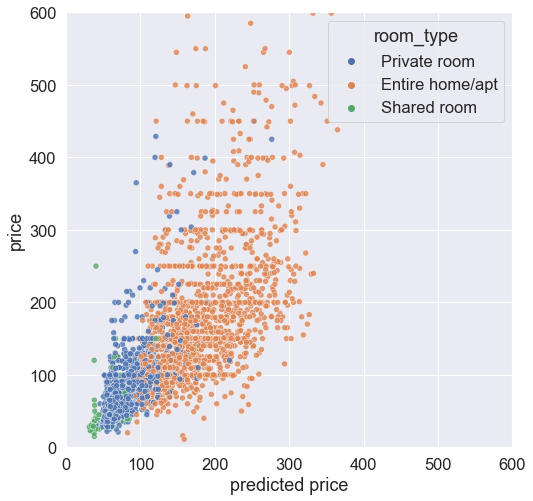

In [156]:
plt.figure(figsize=(8, 8));
sns.scatterplot(data = data, x = 'predicted_price', y = 'price', hue = 'room_type', alpha = 0.8)
plt.xlabel('predicted price')
plt.ylabel('price')
plt.xlim((0, 600))
plt.ylim((0, 600));

more positive bias. makes sense because most of the outliers are unexpected high prices. To precisely predict those outliers, more information are needed, such as the number of guests an apartment/room can host, the time of the listing (peak vs off-peak season), and the amenity available (especially in NYC, buildings are different!)

In [150]:
feature_importances = grid.best_estimator_.feature_importances_

features_sorted = X_test.columns[feature_importances.argsort()][::-1]
feature_importances_sorted = sorted(feature_importances)[::-1]

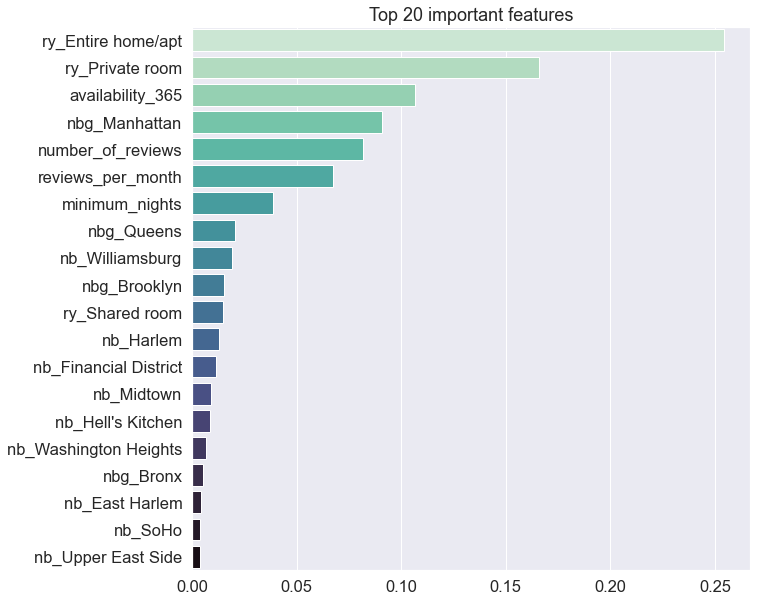

In [293]:
plt.figure(figsize=(10, 10));
sns.barplot(y=features_sorted[:20],x=feature_importances_sorted[:20], palette = 'mako_r');
plt.title('Top 20 important features');

## 3. How to name/describe your listing<a class="anchor" id="third-bullet"></a>

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download(['punkt', 'wordnet','averaged_perceptron_tagger','stopwords'])

In [ ]:
def tokenize(text):
    '''
    Tokenize the text by removing puctuation, normalizing case, splitting by space, removing stop words, 
    lemmatizing, and stemming
    Args:
        text (str): a message 
    Returns:
        tokens (list of str): tokens
    '''
    # replace punctuations with space and normalize all letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize 
    tokens = word_tokenize(text)  
    
    # lemmatize, stem and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(lemmatizer.lemmatize(word)) for word in tokens if word not in stop_words]
    return tokens

In [ ]:
# only use popular listings (with resonable amount of reviews) for title analysis
listings_popular['name']

In [ ]:
tokens_all = collections.Counter()
for 